
# Домашнє завдання: Інтеграція Python та SQL: запити даних

Це ДЗ передбачене під виконання на локальній машині. Виконання з Google Colab буде суттєво ускладнене.

## Підготовка
1. Переконайтесь, що у вас встановлены необхідні бібліотеки:
   ```bash
   pip install sqlalchemy pymysql pandas matplotlib seaborn python-dotenv
   ```

2. Створіть файл `.env` з параметрами підключення до бази даних classicmodels. Базу даних ви можете отримати через

  - docker-контейнер згідно існтрукції в [документі](https://www.notion.so/hannapylieva/Docker-1eb94835849480c9b2e7f5dc22ee4df9), також відео інструкції присутні на платформі - уроки "MySQL бази, клієнт для роботи з БД, Docker і ChatGPT для запитів" та "Як встановити Docker для роботи з базами даних без терміналу"
  - або встановивши локально цю БД - для цього перегляньте урок "Опціонально. Встановлення MySQL та  БД Сlassicmodels локально".
  
  Приклад `.env` файлу ми створювали в лекції. Ось його обовʼязкове наповнення:
    ```
    DB_HOST=your_host
    DB_PORT=3306 або 3307 - той, який Ви налаштували
    DB_USER=your_username
    DB_PASSWORD=your_password
    DB_NAME=classicmodels
    ```
  Якщо ви створили цей файл під час перегляду лекції - **новий створювати не треба**. Замініть лише назву БД, або пропишіть назву в коді створення підключення (замість отримання назви цільової БД зі змінних оточення). Але переконайтесь, що до `.env` файл лежить в тій самій папці, що і цей ноутбук.

  **УВАГА!** НЕ копіюйте скрит для **створення** `.env` файлу. В лекції він наводиться для прикладу. І давалось пояснення, що в реальних проєктах ми НІКОЛИ не пишемо доступи до бази в коді. Копіювання скрипта для створення `.env` файлу сюди в ДЗ буде вважатись грубою помилкою і ми зніматимемо бали.

3. Налаштуйте підключення через SQLAlchemy до БД за прикладом в лекції.

Рекомендую вивести (відобразити) змінну engine після створення. Вона має бути не None! Якщо None - значить у Вас не підтягнулись налаштування з .env файла.

Ви також можете налаштувати параметри підключення до БД без .env файла, просто прописавши текстом в відповідних місцях. Це - не рекомендований підхід.


In [19]:
import datetime
import requests
import json
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy as sa
from sqlalchemy import create_engine, text, MetaData, Table
from sqlalchemy.orm import sessionmaker

In [20]:
def create_connection():
    load_dotenv()
    host = os.getenv('DB_HOST', 'localhost')
    port = os.getenv('DB_PORT', '3306')
    user = os.getenv('DB_USER')
    password = os.getenv('DB_PASSWORD')
    database = os.getenv('DB_NAME')
    if not all([user, password, database]):
        raise ValueError("Не  всі параметри БД задані в .env файлі!")
    connection_string = f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}"
    engine = create_engine(
        connection_string,
        pool_size=2,
        max_overflow=20,
        pool_pre_ping=True,
        echo=False
    )
    try:
        with engine.connect() as conn:
            result = conn.execute(text("SELECT 1"))
            result.fetchone()
        print("Підключення до БД успішне!")
        return engine
    except Exception as e:
        print(f"Помилка підключення: {e}")
        return None 
engine = create_connection()

Підключення до БД успішне!


### Завдання 1: Простий запит (1 бал)

Ми працюємо з БД Classicmodels.

**Виведіть інформацію про продукти на складі** з наступними полями:
- назва продукту (productName)
- лінійка продукту (productLine)
- кількість на складі (quantityInStock)
- ціна закупки (buyPrice)

Зчитайте дані з БД з допомогою `pd.read_sql()` з SQLAlchemy engine, який ви створили на етапі підготовки.

Виведіть перші 10 продуктів, відсортованих за кількістю на складі (від більшої кількості до меншої).

In [21]:
query = """
SELECT productName, productLine, quantityInStock, buyPrice
FROM products
ORDER BY quantityInStock DESC
LIMIT 10;
"""
df = pd.read_sql(query, engine)
display(df)

,productName,productLine,quantityInStock,buyPrice
0,2002 Suzuki XREO,Motorcycles,9997,66.27
1,1995 Honda Civic,Classic Cars,9772,93.89
2,America West Airlines B757-200,Planes,9653,68.80
3,2002 Chevy Corvette,Classic Cars,9446,62.11
4,1932 Model A Ford J-Coupe,Vintage Cars,9354,58.48
5,1982 Ducati 996 R,Motorcycles,9241,24.14
6,1912 Ford Model T Delivery Wagon,Vintage Cars,9173,46.91
7,1976 Ford Gran Torino,Classic Cars,9127,73.49
8,1968 Dodge Charger,Classic Cars,9123,75.16
9,1965 Aston Martin DB5,Classic Cars,9042,65.96



### Завдання 2: Аналітика замовлень за 2004 рік (3 бали)

**Виведіть детальну інформацію про замовлення за 2004 рік** з наступними полями:
- Номер замовлення (orderNumber)
- Дата замовлення (orderDate)
- Статус замовлення (status)
- Ім'я клієнта (customerName)
- Країна клієнта (country)
- Загальна сума замовлення (сума всіх orderdetails.quantityOrdered * orderdetails.priceEach)

Використайте JOIN для об'єднання таблиць orders, customers, orderdetails. Додайте параметризацію за роком (тільки замовлення за 2004 рік).

Використайте `text()` та named parameters для формування запиту з SQLAlchemy.

Після отримання даних з БД проведіть обчислення з Python та напишіть висновки:
1. Побудуйте стовпчасту діаграму суми замовлень по країнам і напишіть, в якій країні найбільша сума замовлень за 2004 рік.
2. В країні з найбільшою кількістю замовлень знайдіть клієнта, який зробив замовлень на найбільшу суму і виведіть імʼя цього клієнта, на яку суму він зробив замовлень і який % від всіх замовлень в цій країні становить його сума замовлень за рік.

In [22]:
year_filter = 2004
query = text("""
SELECT
    o.orderNumber,
    o.orderDate,
    o.status,
    c.customerName,
    c.country,
    SUM(od.quantityOrdered * od.priceEach) AS total_order_amount
FROM orders AS o
JOIN customers AS c ON o.customerNumber = c.customerNumber
JOIN orderdetails AS od ON o.orderNumber = od.orderNumber
WHERE YEAR(o.orderDate) = :year_filter
GROUP BY o.orderNumber, o.orderDate, o.status, c.customerName, c.country
ORDER BY o.orderNumber;
    """)

df = pd.read_sql(query, engine,
                 params={'year_filter': year_filter})
print("Інформація про замовлення за 2004 рік:")
display(df)

Інформація про замовлення за 2004 рік:


,orderNumber,orderDate,status,customerName,country,total_order_amount
0,10208,2004-01-02,Shipped,"Saveley & Henriot, Co.",France,49614.72
1,10209,2004-01-09,Shipped,"Men 'R' US Retailers, Ltd.",USA,21053.69
2,10210,2004-01-12,Shipped,Osaka Souveniers Co.,Japan,47177.59
3,10211,2004-01-15,Shipped,Auto Canal+ Petit,France,49165.16
4,10212,2004-01-16,Shipped,Euro+ Shopping Channel,Spain,59830.55
...,...,...,...,...,...,...
146,10357,2004-12-10,Shipped,Mini Gifts Distributors Ltd.,USA,40676.26
147,10358,2004-12-10,Shipped,Euro+ Shopping Channel,Spain,44185.46
148,10359,2004-12-15,Shipped,Reims Collectables,France,32600.61
149,10360,2004-12-16,Shipped,Kelly's Gift Shop,New Zealand,52166.00


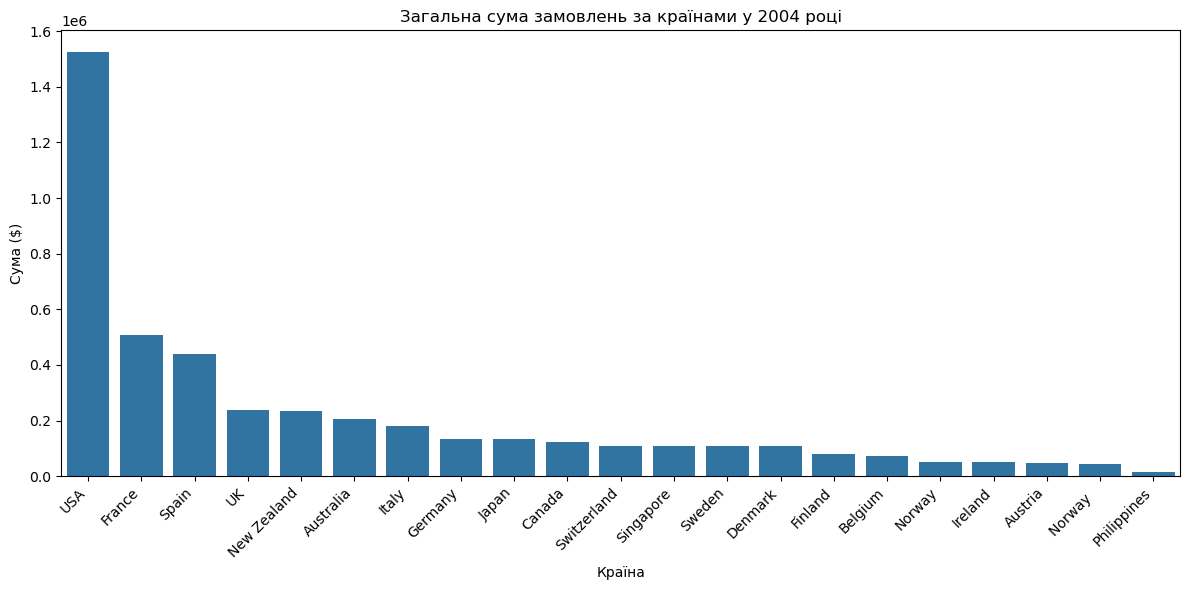

In [23]:
orders_by_country = df.groupby('country')['total_order_amount'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=orders_by_country.index,
           y=orders_by_country.values)
plt.title('Загальна сума замовлень за країнами у 2004 році')
plt.xlabel('Країна')
plt.ylabel('Сума ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [24]:
most_orders_country = orders_by_country.index[0]
print(f'Країна з найбільшою сумою замовлень за 2004 рік: {most_orders_country}')

country_data = df[df['country'] == most_orders_country]

orders_by_customer = country_data.groupby('customerName')['total_order_amount'].sum()

top_customer_name = orders_by_customer.idxmax()
top_customer_amount = orders_by_customer.max()

total_country_amount = orders_by_country[most_orders_country]

percentage_of_total = (top_customer_amount / total_country_amount) * 100
print(f'\n Клієнт з найбільшою сумою замовлень у цій країні: {top_customer_name}')
print(f'Сума його замовлень: ${top_customer_amount:,.2f}')
print(f'Це {percentage_of_total:.2f}% від загальної суми замовлень у {most_orders_country}')      


Країна з найбільшою сумою замовлень за 2004 рік: USA

 Клієнт з найбільшою сумою замовлень у цій країні: Mini Gifts Distributors Ltd.
Сума його замовлень: $231,562.53
Це 15.17% від загальної суми замовлень у USA



### Завдання 3: Аналітичний запит - Топ продуктів по продажах (6 балів)

В цьому завданні ви отримуєте 1 бал за правильний SQL запит і по 1 балу за кожне завдання з Python.

**Проведіть аналіз прибутковості продуктів** та для цього дістаньте з БД інформацію з наступними полями:
- Назва продукту
- Лінійка продукту (productLine)
- Загальний дохід з цього продукту (сума quantity * priceEach)
- Ранг продукту по доходу (тобто яке місце посідає цей продукт за доходом серед усіх продуктів в нашому магазині)
- Який відсоток від загального доходу компанії складає цей продукт
- Різниця з середнім доходом по лінійці продукту (в %)

Відсортуйте дані за спаданням значень колонки "Який відсоток від загального доходу компанії складає цей продукт".

При створенні SQL запиту вам можуть стати в нагоді:
- **CTE** для розрахунку доходу по кожному продукту
- **Віконні функції** для ранжування та порівняння з середнім

Після отримання даних з БД проведіть обчислення (де треба) з Python та напишіть висновки:
1. Який відсоток від загального доходу складає ТОП1 продукт і що це за продукт?
2. Створіть стовпчикову діаграму топ-10 продуктів по доходу. В скільки разів відрізняється сумарний дохід за ТОП1 продуктом від 10го продукту за сумою доходу?
3. Створіть кругову діаграму розподілу доходу по лініях продуктів. Який відсоток від всіх продажів становлять продажі за ТОП2 лініями сумарно?
4. Розрахуйте та виведіть за принципом Парето (80/20) - скільки продуктів дають 80% доходу. Тобто нам треба знайти кількість продуктів сумарне значення "відсотку від загального доходу компанії", яких складає 80 починаючи з продукту з найбільшим цим відсотком.
5. Зробіть ще будь-яке аналітичне дослідження, яке дасть нам більше розуміння наших даних, що ми дістали в БД в цьому завданні. Сформоване питання до даних і обчислення має бути обовʼязково. Візуалізація - опціонально.

Візуалізацію можна створювати з будь-якою бібліотекою на ваш вибір.

In [25]:
query = text("""
WITH product_revenue AS (
    SELECT
        p.productName,
        p.productline,
        SUM(od.quantityOrdered * od.priceEach) AS revenue
    FROM orderdetails od
    JOIN products p ON od.productCode = p.productCode
    GROUP BY p.productName, p.productline),
company_stats AS (
    SELECT 
        SUM(revenue) AS total_company_revenue
    FROM product_revenue)
SELECT
    pr.productName,
    pr.productline,
    pr.revenue,
    RANK() OVER (ORDER BY pr.revenue DESC) AS revenue_rank,
    ROUND(pr.revenue / cs.total_company_revenue * 100, 2) AS pct_of_total,
    ROUND((pr.revenue - AVG(pr.revenue) OVER(PARTITION BY pr.productline)) /
    AVG(pr.revenue) OVER(PARTITION BY pr.productline) * 100, 2) AS diff_from_line_avg_pct
FROM product_revenue pr, company_stats cs
ORDER BY pct_of_total DESC
""")
df = pd.read_sql(query, engine)
display(df.head(10))
         
         

,productName,productline,revenue,revenue_rank,pct_of_total,diff_from_line_avg_pct
0,1992 Ferrari 360 Spider red,Classic Cars,276839.98,1,2.88,165.78
1,2001 Ferrari Enzo,Classic Cars,190755.86,2,1.99,83.14
2,1952 Alpine Renault 1300,Classic Cars,190017.96,3,1.98,82.43
3,2003 Harley-Davidson Eagle Drag Bike,Motorcycles,170686.00,4,1.78,97.87
4,1968 Ford Mustang,Classic Cars,161531.48,5,1.68,55.08
5,1969 Ford Falcon,Classic Cars,152543.02,6,1.59,46.45
6,1980s Black Hawk Helicopter,Planes,144959.91,7,1.51,82.22
7,1998 Chrysler Plymouth Prowler,Classic Cars,142530.63,8,1.48,36.84
8,1917 Grand Touring Sedan,Vintage Cars,140535.60,9,1.46,87.64
9,2002 Suzuki XREO,Motorcycles,135767.03,10,1.41,57.39


In [26]:
top1 = df.iloc[0]
print(f'Топ1 продукт: {top1['productName']}')
print(f'Дохід: {top1['revenue']: .2f}')
print(f'Частка від загального доходу: {top1['pct_of_total']}%')

Топ1 продукт: 1992 Ferrari 360 Spider red
Дохід:  276839.98
Частка від загального доходу: 2.88%


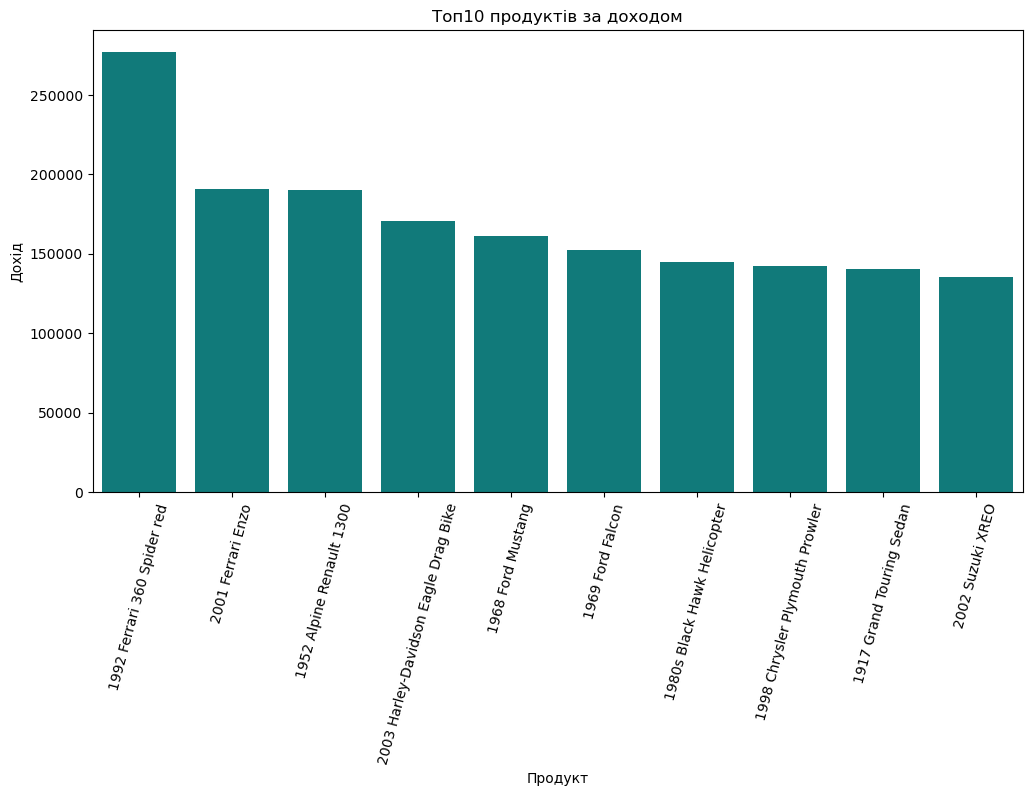

Дохід ТОП1 продукту у 2.0 рази більший, ніж у 10го продукту.


In [27]:
top10 = df.nlargest(10, 'revenue')
plt.figure(figsize=(12, 6))
sns.barplot(x='productName', y='revenue', data=top10, color='darkcyan')
plt.xticks(rotation=75)
plt.title('Топ10 продуктів за доходом')
plt.xlabel('Продукт')
plt.ylabel('Дохід')
plt.show()

ratio = top10.iloc[0]['revenue'] / top10.iloc[9]['revenue']
print(f'Дохід ТОП1 продукту у {ratio:.1f} рази більший, ніж у 10го продукту.')

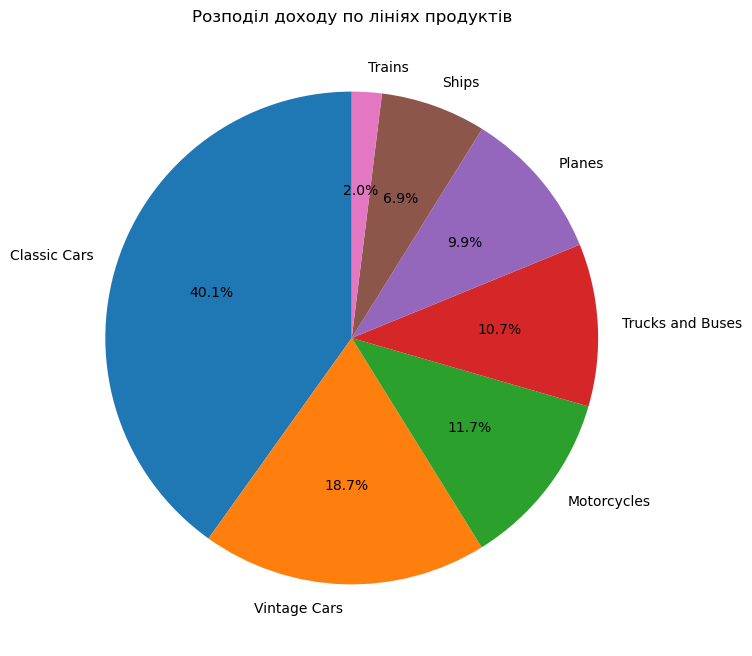

Дві найбільші лінії продуктів разом дають 58.8% від усіх продажів.


In [28]:
line_share = df.groupby('productline')['revenue'].sum().sort_values(ascending=False)
plt.figure(figsize=(8, 8))
plt.pie(line_share, labels=line_share.index, autopct='%1.1f%%', startangle=90)
plt.title('Розподіл доходу по лініях продуктів')
plt.show()

top2_share = line_share.iloc[0:2].sum() / line_share.sum() * 100
print(f'Дві найбільші лінії продуктів разом дають {top2_share:.1f}% від усіх продажів.')

In [29]:
df_sorted = df.sort_values('pct_of_total', ascending=False)
df_sorted['cum_pct'] = df_sorted['pct_of_total'].cumsum()
pareto_count = (df_sorted['cum_pct'] <= 80).sum()
print(f'Для досягнення 80% доходу достатньо {pareto_count} продуктів.')

Для досягнення 80% доходу достатньо 71 продуктів.



 Середній дохід на продукт по лініях:


productline
Classic Cars        104160.07
Trucks and Buses     93101.23
Motorcycles          86263.55
Planes               79553.13
Vintage Cars         74898.32
Ships                73777.59
Trains               62844.31
Name: revenue, dtype: float64

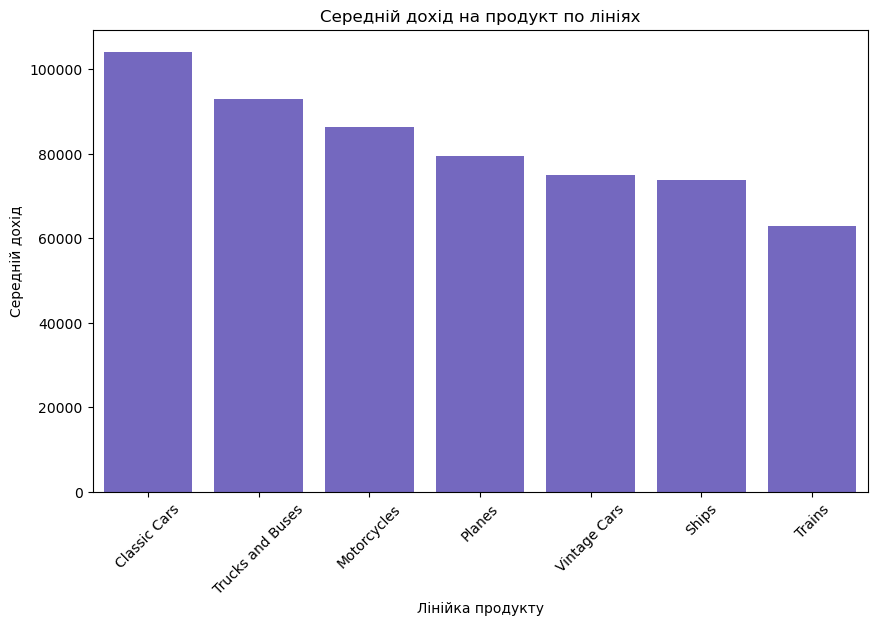

In [30]:
## Додаткове обчислення. Яка лінія продуктів має найвищий середній дохід на продукт?

line_avg = df.groupby('productline')['revenue'].mean().sort_values(ascending=False).round(2)
print("\n Середній дохід на продукт по лініях:")
display(line_avg)

plt.figure(figsize=(10, 6))
sns.barplot(x=line_avg.index, y=line_avg.values, color='slateblue')
plt.xticks(rotation=45)
plt.title('Середній дохід на продукт по лініях')
plt.ylabel('Середній дохід')
plt.xlabel('Лінійка продукту')
plt.show()

### ОПЦІОНАЛЬНО. Завдання 4: Аналітичний запит - Динаміка продажів по місяцях (8 балів)

**Проведіть аналіз динаміки продажів по місяцях** та для цього дістаньте з бази інформацію з наступними полями:
- Рік та місяць замовлень
- Кількість замовлень за цей рік-місяць
- Загальний дохід (quantityOrdered * priceEach) за цей рік-місяць
- На який % ми зросли за доходом порівняно з попереднім місяцем
- Накопичувальний дохід до цього місяця за рік
- Ковзне середнє доходу за 3 місяці
- Ранг цього місяця за доходом

Використайте:
- **CTE** для агрегації продажів по місяцях
- **Віконні функції** для розрахунку:
  - Зростання доходу порівняно з попереднім місяцем (LAG)
  - Накопичувальний дохід за рік
  - Ковзне середнє доходу за 3 місяці (AVG OVER)
  - Ранжування місяців за доходом (RANK)

Після отримання даних з БД побудуйте наступні графіки і напишіть коротко, які висновки з них можна зробити.
1. Створіть лінійний графік доходу по місяцях. Чи є тред до зростання в даних?
2. Створіть графік місяць-до-місяця зростання у відсотках.
3. Створіть heatmap сезонності (місяць vs рік)
4. Відобразіть козвне середнє разом з динамікою продажів.
5. Розрахуйте кореляцію між кількістю замовлень та середнім чеком та побудуйте графік розсіювання між цими змінними. Чи є лінійна залежність?

Очікуваний результат кожного графіку - нижче.
В першому графіку я додала лінію тренду аби показати тренд. Вам її додавати не треба.


In [31]:
query = text("""
WITH monthly_sales AS (
    SELECT
        YEAR(o.orderDate) AS order_year,
        MONTH(o.orderDate) AS order_month,
        COUNT(DISTINCT o.orderNumber) AS orders_count,
        SUM(od.quantityOrdered * od.priceEach) AS revenue
    FROM orders o
    JOIN orderdetails od ON o.orderNumber = od.orderNumber
    GROUP BY YEAR(o.orderDate), MONTH(o.orderdate)
)
SELECT 
    order_year,
    order_month,
    orders_count,
    revenue,
    ROUND(
        (revenue - LAG(revenue) OVER (ORDER BY order_year, order_month))
        / NULLIF(LAG(revenue) OVER (ORDER BY order_year, order_month), 0) * 100, 2) AS pct_growth, 
    SUM(revenue) OVER (PARTITION BY order_year ORDER BY order_month) AS cumulative_revenue,
    ROUND(
        AVG(revenue) OVER (ORDER BY order_year, order_month ROWS BETWEEN 2 PRECEDING AND CURRENT ROW), 2) AS moving_avg_3m,
    RANK() OVER (ORDER BY revenue DESC) AS revenue_rank
FROM monthly_sales
ORDER BY order_year, order_month
    """)
monthly_df = pd.read_sql(query, engine)
display(monthly_df.head())

,order_year,order_month,orders_count,revenue,pct_growth,cumulative_revenue,moving_avg_3m,revenue_rank
0,2003,1,5,116692.77,NaN,116692.77,116692.77,29
1,2003,2,3,128403.64,10.04,245096.41,122548.21,28
2,2003,3,6,160517.14,25.01,405613.55,135204.52,26
3,2003,4,7,185848.59,15.78,591462.14,158256.46,23
4,2003,5,6,179435.55,-3.45,770897.69,175267.09,24


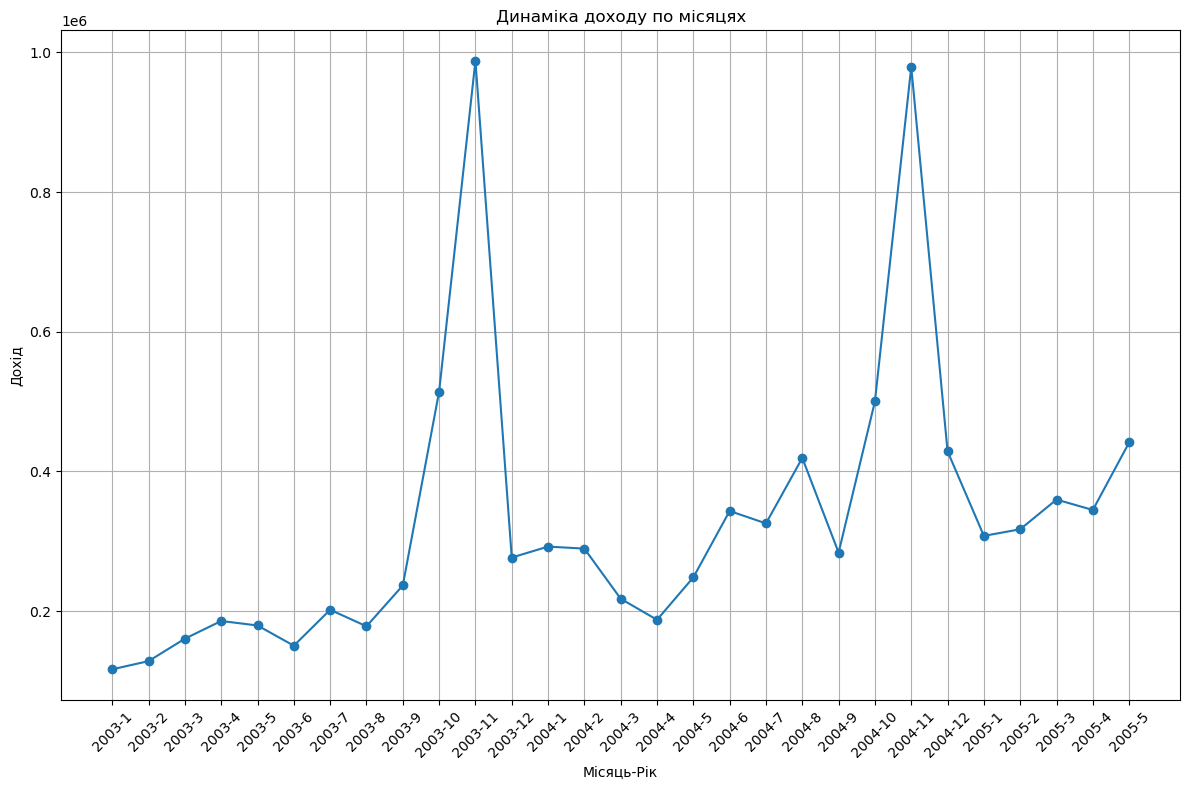

In [32]:
# 1. Лінійний графік доходу з трендом (аби показати, що тренд є)

plt.figure(figsize=(12, 8))
plt.plot(monthly_df['order_year'].astype(str) + '-' + 
         monthly_df['order_month'].astype(str), monthly_df['revenue'],
marker='o',
linestyle='-')
plt.title('Динаміка доходу по місяцях')
plt.xlabel('Місяць-Рік')
plt.ylabel('Дохід')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

**З цього графіку видно, що тренд до зростання даних - є.**

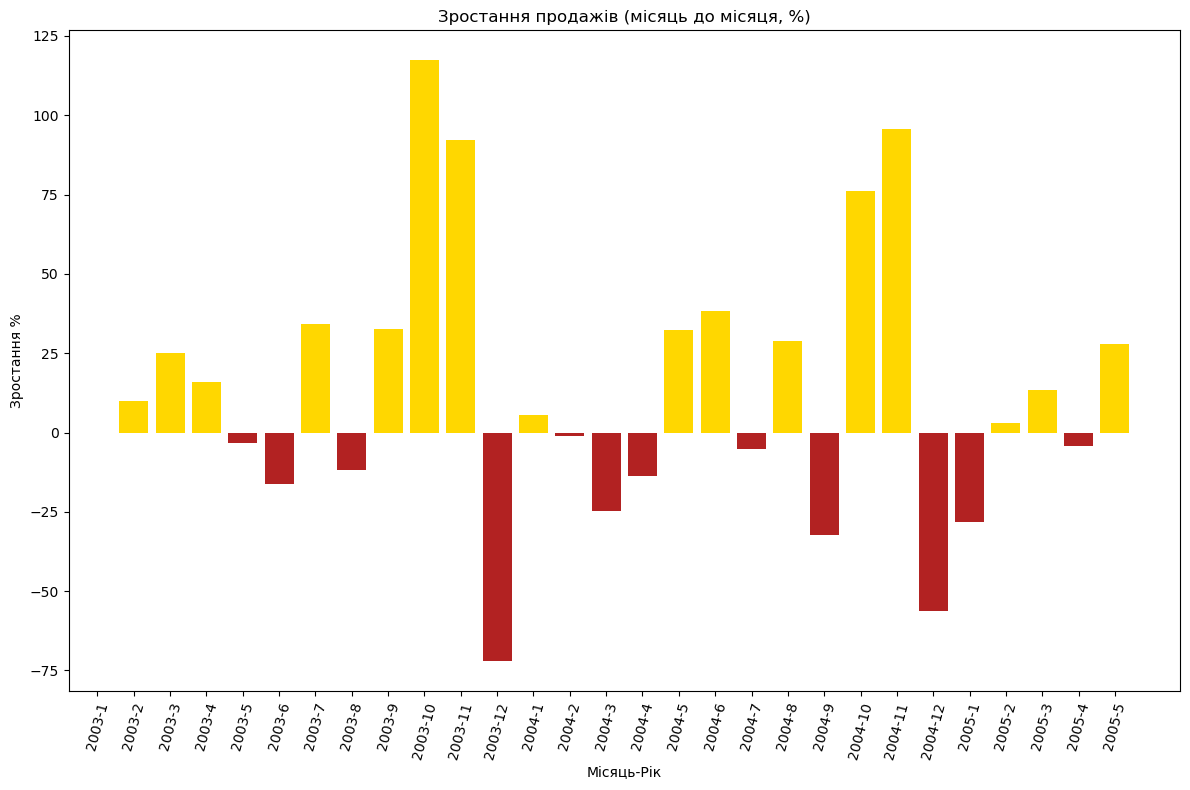

In [33]:
# 2. Місяць-до-місяця зростання
colors = ['gold' if growth > 0
         else 'firebrick' for growth in monthly_df['pct_growth']]

plt.figure(figsize=(12, 8))
plt.bar(monthly_df['order_year'].astype(str) + '-' +
       monthly_df['order_month'].astype(str), monthly_df['pct_growth'],
       color=colors)
plt.title('Зростання продажів (місяць до місяця, %)')
plt.xlabel('Місяць-Рік')
plt.ylabel('Зростання %')
plt.xticks(rotation=75)
plt.grid(False)
plt.tight_layout()
plt.show()


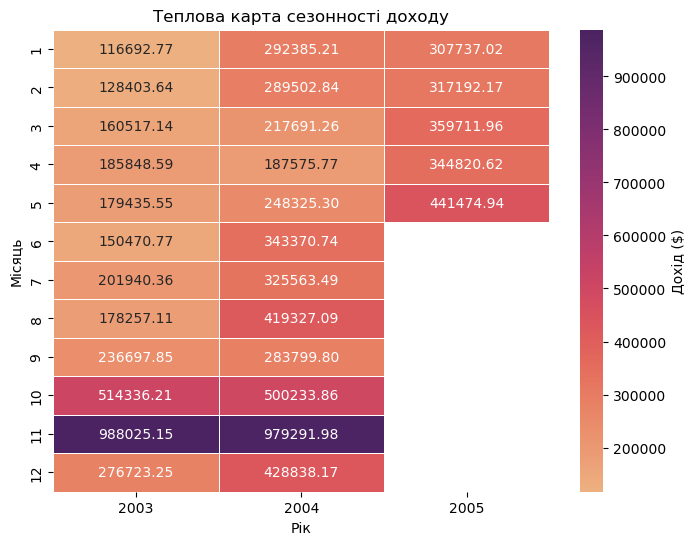

In [34]:
# 3. Heatmap сезонності

pivot_table = monthly_df.pivot_table(values='revenue', index='order_month', columns='order_year')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap='flare', fmt='.2f', linewidths=.5, cbar_kws={'label': 'Дохід ($)'})
plt.title('Теплова карта сезонності доходу')
plt.xlabel('Рік')
plt.ylabel('Місяць')
plt.show()

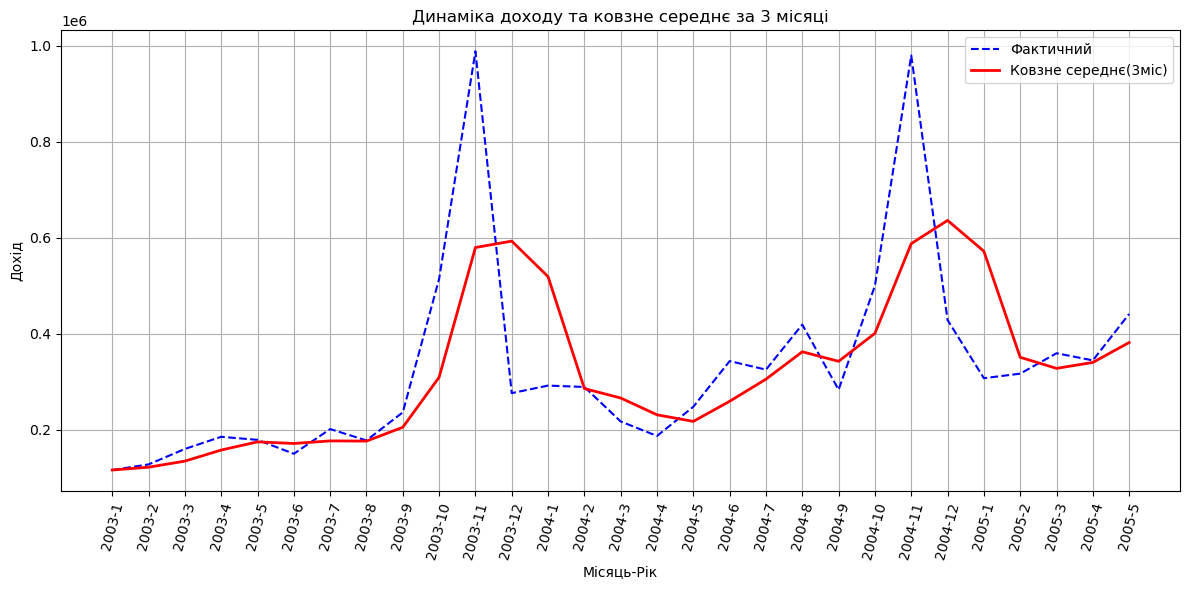

In [35]:
# 4. Ковзне середнє з динімікою доходу

plt.figure(figsize=(12, 6))
plt.plot(monthly_df['order_year'].astype(str) + '-' + 
        monthly_df['order_month'].astype(str), monthly_df['revenue'],
label='Фактичний', color='blue', linestyle='--')
plt.plot(monthly_df['order_year'].astype(str) + '-' +
        monthly_df['order_month'].astype(str),
        monthly_df['moving_avg_3m'],
label='Ковзне середнє(3міс)', color='red', linewidth=2)
plt.title('Динаміка доходу та ковзне середнє за 3 місяці')
plt.xlabel('Місяць-Рік')
plt.ylabel('Дохід')
plt.xticks(rotation=75)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Кореляція між кількістю замовлень та середнім чеком: 0.017


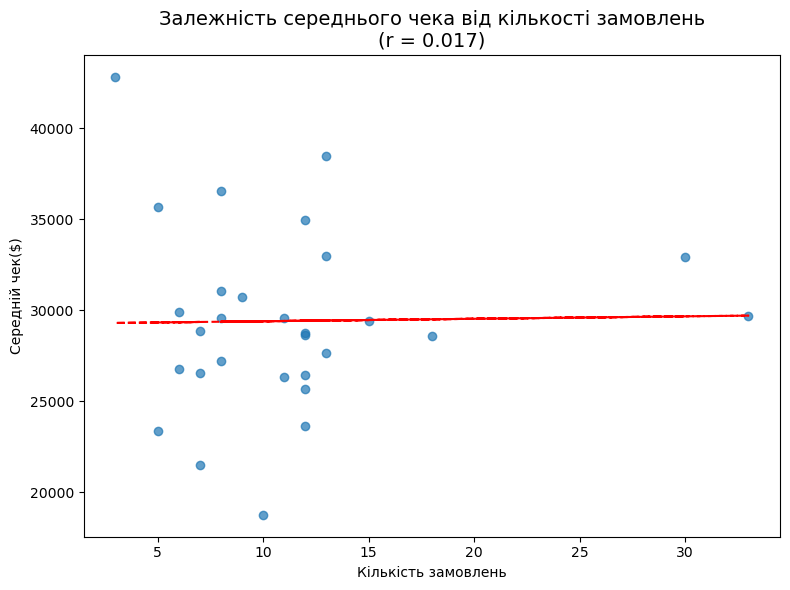

In [36]:
# 5. Кореляція замовлень та середнього чеку
# Середній чек.

monthly_df['average_check'] = monthly_df['revenue'] / monthly_df['orders_count']

correlation = monthly_df['orders_count'].corr(monthly_df['average_check'])
print(f'Кореляція між кількістю замовлень та середнім чеком: {correlation:.3f}')

plt.figure(figsize=(8, 6))
plt.scatter(monthly_df['orders_count'], monthly_df['average_check'], alpha=0.7)
x = monthly_df['orders_count']
y = monthly_df['average_check']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), 'r--')            
plt.title(f'Залежність середнього чека від кількості замовлень\n(r = {correlation:.3f})', fontsize=14)
plt.xlabel('Кількість замовлень')
plt.ylabel('Середній чек($)')
plt.tight_layout()
plt.show()


**Лінійної залежності між кількістю замовлень та середнім чеком немає.**